In [1]:
import pandas as pd
import numpy as np
import glob
import datetime as dt
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_scws(rid):
    print("loading "+rid+"...")
    df1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_scw_envs_df.csv")
    df2 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_non_scw_envs_df.csv")
    df1["rid"]=rid
    df2["rid"]=rid
    return df1, df2

In [3]:
melb_scw, melb_null = load_scws("2")
bris_scw, bris_null = load_scws("66")
namoi_scw, namoi_null = load_scws("69")
perth_scw, perth_null = load_scws("70")
syd_scw, syd_null = load_scws("71")

loading 2...
loading 66...
loading 69...
loading 70...
loading 71...


In [4]:
df_scw = pd.concat([melb_scw, bris_scw, namoi_scw, perth_scw, syd_scw], axis=0)
df_null = pd.concat([melb_null, bris_null, namoi_null, perth_null, syd_null], axis=0)

In [ ]:
df_scw1 = df_scw.query("cluster==0")
df_scw2 = df_scw.query("cluster==2")
df_scw3 = df_scw.query("cluster==1")
df_null1 = df_null.query("cluster==0")
df_null2 = df_null.query("cluster==2")
df_null3 = df_null.query("cluster==1")

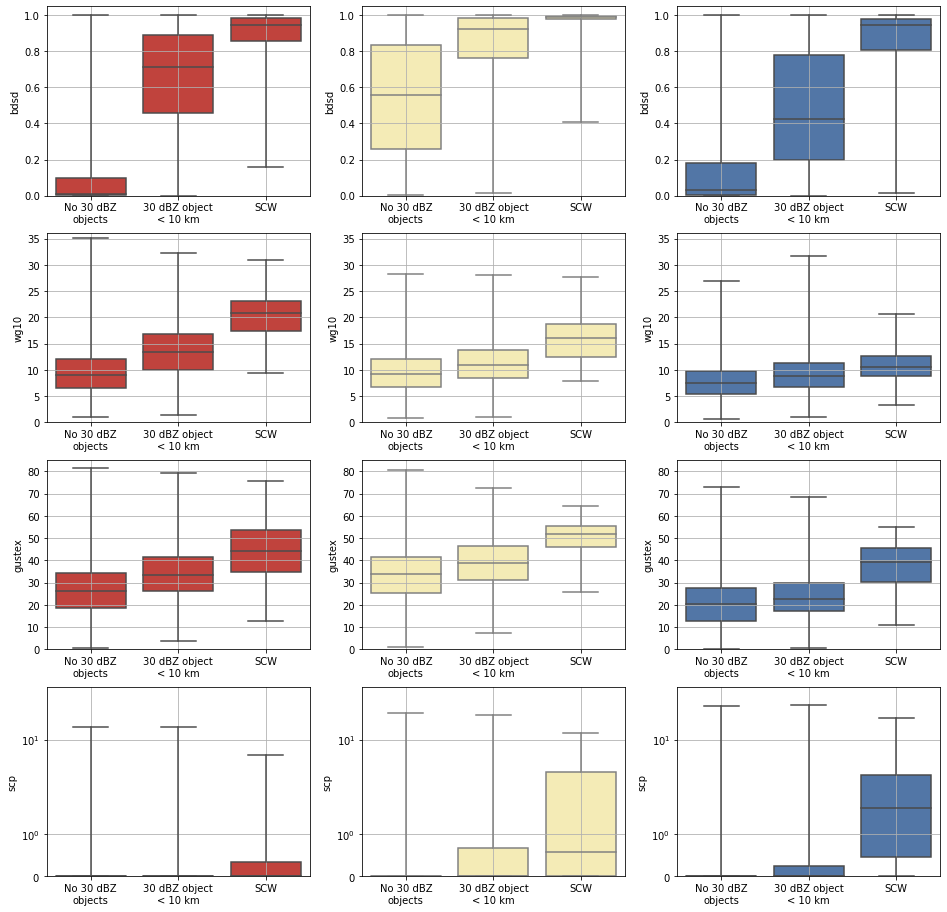

In [6]:
def plot_box_clusters(event,null,v,ax1,color,y0=None,y1=None,yscale="linear"):
    
    data1=null
    data2=event
    sns.boxplot(data=[data1.query("(in10km==0)")[v],
                     data1.query("(in10km==1)")[v],
                     data2[v]],color=color,ax=ax1, whis=[0,100])
    ax1.set_yscale(yscale); ax1.set_ylim([y0,y1])
    ax1.set_ylabel(v)
    ax1.set_xticks([0,1,2],["No 30 dBZ\nobjects", "30 dBZ object\n< 10 km", "SCW"])
    ax1.grid()

#     data1=null.query("cluster==2")
#     data2=event.query("cluster==2")
#     sns.boxplot(data=[data1.query("(in10km==0)")[v],
#                      data1.query("(in10km==1)")[v],
#                      data2[v]],whis=10000,color=p[1],ax=ax2)
#     ax2.set_yscale(yscale); ax2.set_ylim([y0,y1])
#     ax2.set_ylabel(v)
#     ax2.set_xticks([0,1,2],["No 30 dBZ\nobjects", "30 dBZ object\n< 10 km", "SCW"])
#     ax2.grid()

#     data1=null.query("cluster==1")
#     data2=event.query("cluster==1")
#     sns.boxplot(data=[data1.query("(in10km==0)")[v],
#                      data1.query("(in10km==1)")[v],
#                      data2[v]],whis=10000,color=p[2],ax=ax3)
#     ax3.set_yscale(yscale); ax3.set_ylim([y0,y1])
#     ax3.set_ylabel(v)
#     ax3.set_xticks([0,1,2],["No 30 dBZ\nobjects", "30 dBZ object\n< 10 km", "SCW"])
#     ax3.grid()
    
plt.figure(figsize=[16,16])
row=4; col=3
p = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]

plot_box_clusters(df_scw1,df_null1,"bdsd",plt.subplot(row,col,1),p[0],y0=0,y1=1.05)
plot_box_clusters(df_scw2,df_null2,"bdsd",plt.subplot(row,col,2),p[1],y0=0,y1=1.05)
plot_box_clusters(df_scw3,df_null3,"bdsd",plt.subplot(row,col,3),p[2],y0=0,y1=1.05)

plot_box_clusters(df_scw1,df_null1,"wg10",plt.subplot(row,col,4),p[0],y0=0,y1=36)
plot_box_clusters(df_scw2,df_null2,"wg10",plt.subplot(row,col,5),p[1],y0=0,y1=36)
plot_box_clusters(df_scw3,df_null3,"wg10",plt.subplot(row,col,6),p[2],y0=0,y1=36)

plot_box_clusters(df_scw1,df_null1,"gustex",plt.subplot(row,col,7),p[0],y0=0,y1=85)
plot_box_clusters(df_scw2,df_null2,"gustex",plt.subplot(row,col,8),p[1],y0=0,y1=85)
plot_box_clusters(df_scw3,df_null3,"gustex",plt.subplot(row,col,9),p[2],y0=0,y1=85)

plot_box_clusters(df_scw1,df_null1,"scp",plt.subplot(row,col,10),p[0],y0=0,yscale="symlog",y1=50)
plot_box_clusters(df_scw2,df_null2,"scp",plt.subplot(row,col,11),p[1],y0=0,yscale="symlog",y1=50)
plot_box_clusters(df_scw3,df_null3,"scp",plt.subplot(row,col,12),p[2],y0=0,yscale="symlog",y1=50)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_cluster_env_boxplot.jpeg",dpi=1000,bbox_inches="tight")

In [7]:
def skill(events, nulls, t, v, score="TSS"):
    
    hits = (events[v]>=t).sum()
    misses = (events[v]<t).sum()    
    fa = (nulls[v]>=t).sum()
    cn = (nulls[v]<t).sum()
    
    if score=="TSS":
        return (( (hits) / (hits+misses) )  - ( (fa) / (fa+cn) ))
    elif score=="HSS":
        if hits / (hits + misses) > 0.66:
            return ( 2*(hits*cn - misses*fa) ) / ( misses*misses + fa*fa + 2*hits*cn + (misses + fa) * (hits + cn) )
        else:
            return 0

def plot_skill(events, nulls, v, ax, color):
    x=np.linspace(0,nulls[v].quantile(.975),50)
    ax.plot(x,[skill(events,nulls,i,v) for i in x],color=color,marker="x")
    ax.set_facecolor("lightgray"); ax.set_ylim([0,1]); ax.set_xlabel(v+" threshold"); ax.set_ylabel("TSS"); ax.grid()

p = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]    

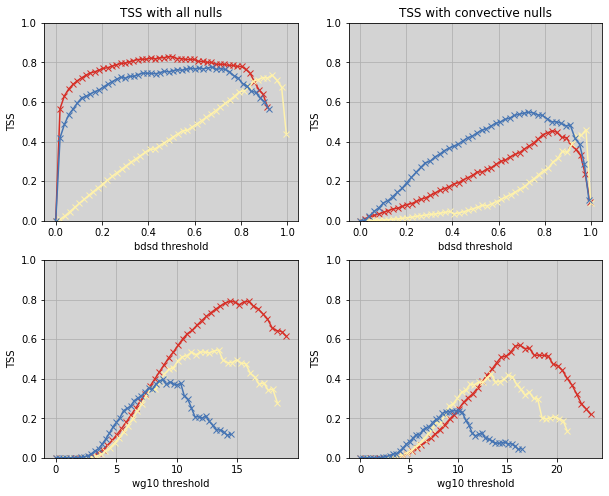

In [8]:
#For all locations combined...

plt.figure(figsize=[10,8]); 

rows=2; cols=2

ax=plt.subplot(rows,cols,1); ax2=plt.subplot(rows,cols,2)
v="bdsd"
plot_skill(df_scw.query("cluster==0"),df_null.query("cluster==0"),v,ax,p[0])
plot_skill(df_scw.query("cluster==2"),df_null.query("cluster==2"),v,ax,p[1])
plot_skill(df_scw.query("cluster==1"),df_null.query("cluster==1"),v,ax,p[2])
plot_skill(df_scw.query("cluster==0"),df_null.query("(cluster==0) & (in10km==1)"),v,ax2,p[0])
plot_skill(df_scw.query("cluster==2"),df_null.query("(cluster==2) & (in10km==1)"),v,ax2,p[1])
plot_skill(df_scw.query("cluster==1"),df_null.query("(cluster==1) & (in10km==1)"),v,ax2,p[2])
ax.set_title("TSS with all nulls")
ax2.set_title("TSS with convective nulls")

ax=plt.subplot(rows,cols,3); ax2=plt.subplot(rows,cols,4)
v="wg10"
plot_skill(df_scw.query("cluster==0"),df_null.query("cluster==0"),v,ax,p[0])
plot_skill(df_scw.query("cluster==2"),df_null.query("cluster==2"),v,ax,p[1])
plot_skill(df_scw.query("cluster==1"),df_null.query("cluster==1"),v,ax,p[2])
plot_skill(df_scw.query("cluster==0"),df_null.query("(cluster==0) & (in10km==1)"),v,ax2,p[0])
plot_skill(df_scw.query("cluster==2"),df_null.query("(cluster==2) & (in10km==1)"),v,ax2,p[1])
plot_skill(df_scw.query("cluster==1"),df_null.query("(cluster==1) & (in10km==1)"),v,ax2,p[2])

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_cluster_env_tss.jpeg",dpi=1000,bbox_inches="tight")

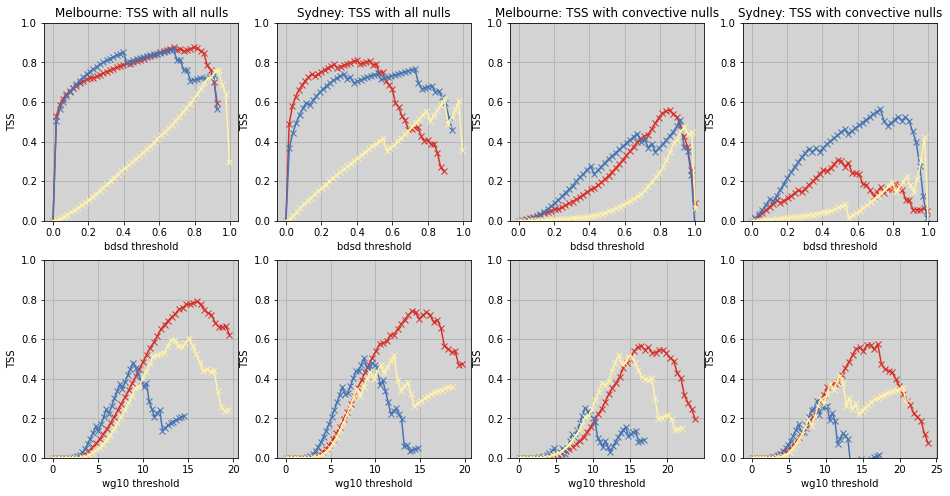

In [9]:
#SCWs versus all other events - regional variations.

plt.figure(figsize=[16,8]); 

ax=plt.subplot(2,4,1)
plot_skill(melb_scw.query("cluster==0"),melb_null.query("cluster==0"),"bdsd",ax,p[0])
plot_skill(melb_scw.query("cluster==1"),melb_null.query("cluster==1"),"bdsd",ax,p[2])
plot_skill(melb_scw.query("cluster==2"),melb_null.query("cluster==2"),"bdsd",ax,p[1])
ax.set_title("Melbourne: TSS with all nulls")

ax=plt.subplot(2,4,5)
plot_skill(melb_scw.query("cluster==0"),melb_null.query("cluster==0"),"wg10",ax,p[0])
plot_skill(melb_scw.query("cluster==1"),melb_null.query("cluster==1"),"wg10",ax,p[2])
plot_skill(melb_scw.query("cluster==2"),melb_null.query("cluster==2"),"wg10",ax,p[1])

ax=plt.subplot(2,4,3)
plot_skill(melb_scw.query("cluster==0"),melb_null.query("(cluster==0) & (in10km==1)"),"bdsd",ax,p[0])
plot_skill(melb_scw.query("cluster==1"),melb_null.query("(cluster==1) & (in10km==1)"),"bdsd",ax,p[2])
plot_skill(melb_scw.query("cluster==2"),melb_null.query("(cluster==2) & (in10km==1)"),"bdsd",ax,p[1])
ax.set_title("Melbourne: TSS with convective nulls")

ax=plt.subplot(2,4,7)
plot_skill(melb_scw.query("cluster==0"),melb_null.query("(cluster==0) & (in10km==1)"),"wg10",ax,p[0])
plot_skill(melb_scw.query("cluster==1"),melb_null.query("(cluster==1) & (in10km==1)"),"wg10",ax,p[2])
plot_skill(melb_scw.query("cluster==2"),melb_null.query("(cluster==2) & (in10km==1)"),"wg10",ax,p[1])

ax=plt.subplot(2,4,2)
plot_skill(syd_scw.query("cluster==0"),syd_null.query("cluster==0"),"bdsd",ax,p[0])
plot_skill(syd_scw.query("cluster==1"),syd_null.query("cluster==1"),"bdsd",ax,p[2])
plot_skill(syd_scw.query("cluster==2"),syd_null.query("cluster==2"),"bdsd",ax,p[1])
ax.set_title("Sydney: TSS with all nulls")

ax=plt.subplot(2,4,6)
plot_skill(syd_scw.query("cluster==0"),syd_null.query("cluster==0"),"wg10",ax,p[0])
plot_skill(syd_scw.query("cluster==1"),syd_null.query("cluster==1"),"wg10",ax,p[2])
plot_skill(syd_scw.query("cluster==2"),syd_null.query("cluster==2"),"wg10",ax,p[1])

ax=plt.subplot(2,4,4)
plot_skill(syd_scw.query("cluster==0"),syd_null.query("(cluster==0) & (in10km==1)"),"bdsd",ax,p[0])
plot_skill(syd_scw.query("cluster==1"),syd_null.query("(cluster==1) & (in10km==1)"),"bdsd",ax,p[2])
plot_skill(syd_scw.query("cluster==2"),syd_null.query("(cluster==2) & (in10km==1)"),"bdsd",ax,p[1])
ax.set_title("Sydney: TSS with convective nulls")

ax=plt.subplot(2,4,8)
plot_skill(syd_scw.query("cluster==0"),syd_null.query("(cluster==0) & (in10km==1)"),"wg10",ax,p[0])
plot_skill(syd_scw.query("cluster==1"),syd_null.query("(cluster==1) & (in10km==1)"),"wg10",ax,p[2])
plot_skill(syd_scw.query("cluster==2"),syd_null.query("(cluster==2) & (in10km==1)"),"wg10",ax,p[1])


plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_cluster_env_tss_regional.jpeg",dpi=1000,bbox_inches="tight")

In [10]:
df_scw0 = df_scw[df_scw.cluster==0]
df_scw1 = df_scw[df_scw.cluster==1]
df_scw2 = df_scw[df_scw.cluster==2]

df_null0 = df_null[df_null.cluster==0]
df_null1 = df_null[df_null.cluster==1]
df_null2 = df_null[df_null.cluster==2]

In [29]:
def skill_test(scw,null,v,score="TSS"):
    x=np.linspace(0,null[v].quantile(.975),50)
    tss = [skill(scw,null,i,v,score=score) for i in x]
    return np.max(tss), x[np.argmax(tss)]

#test_vars = ["wg10","bdsd"]
test_vars = list(df_scw.columns[41:-6])
output_tss = {0:[],1:[],2:[],3:[]}
output_t = {0:[],1:[],2:[],3:[]}
for v in tqdm.tqdm(test_vars):
    cnt=0
    for scw, null in zip([df_scw,df_scw0,df_scw1,df_scw2],[df_null,df_null0,df_null1,df_null2]):
        tss, t = skill_test(scw,null,v,score="TSS")
        output_tss[cnt].append(tss)
        output_t[cnt].append(t)        
        cnt=cnt+1

100%|██████████| 121/121 [03:42<00:00,  1.84s/it]


In [30]:
#All events
tss = pd.DataFrame({"tss_all":output_tss[0],"t_all":output_t[0],
                   "tss1":output_tss[1],"t1":output_t[1],
                    "tss3":output_tss[2],"t3":output_t[2],
                    "tss2":output_tss[3],"t2":output_t[3]
                   }, index=test_vars)

In [31]:
tss

,tss_all,t_all,tss1,t1,tss3,t3,tss2,t2
ml_cape,0.481451,33.602041,0.526430,22.071429,0.705461,379.616071,0.442796,17.715561
mu_cape,0.484636,112.314126,0.603882,72.815051,0.696882,1029.602041,0.419368,300.607143
sb_cape,0.491202,104.158163,0.557600,66.547194,0.686779,890.464286,0.491446,300.447959
ml_cin,0.354020,6.382653,0.468074,2.719388,0.393409,7.582908,0.395675,9.089286
sb_cin,0.223111,8.173469,0.259789,2.433673,0.283266,18.234694,0.265815,14.536990
...,...,...,...,...,...,...,...,...
vo10,0.061459,7.357372,0.127686,7.430345,-0.009272,4.654894,0.039045,4.060123
mod_cape,0.525895,56.331983,0.628283,18.022959,0.699882,229.679082,0.390633,49.976531
cp,0.141434,0.003458,0.114418,0.166596,0.211901,0.003727,0.289089,0.000964
mod_cape*s06,0.615820,5318.078196,0.659208,4642.071429,0.692651,15194.267857,0.398024,4859.367347


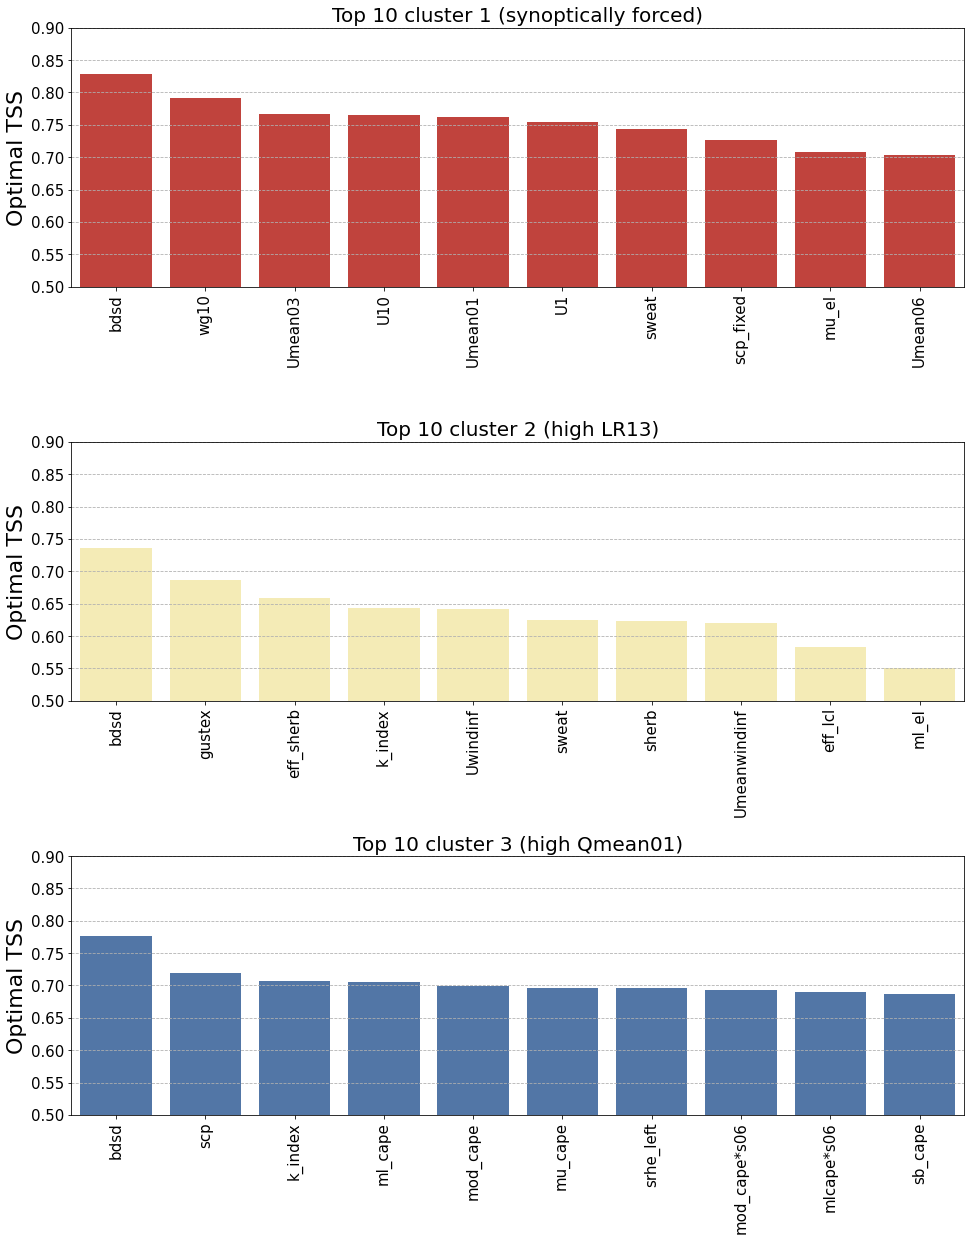

In [32]:
# plt.figure(figsize=[20,6])
# sns.barplot(data=tss.sort_values("tss_all",ascending=False).iloc[0:50].reset_index(),y="tss_all",x="index",color="tab:blue")
# plt.gca().tick_params(axis="x",labelrotation=90)
# plt.title("Top 50 all clusters combined\nNulls = all non-SCWs")
# plt.ylim([0,1])

plt.figure(figsize=[16,20])

plt.subplot(3,1,1)
sns.barplot(data=tss.sort_values("tss1",ascending=False).iloc[0:10].reset_index(),y="tss1",x="index",color=p[0])
plt.gca().tick_params(axis="x",labelrotation=90)
plt.title("Top 10 cluster 1 (synoptically forced)",size=20)
plt.ylim([0.5,.9])
plt.gca().tick_params(labelsize=15)
plt.ylabel("Optimal TSS",size=22)
plt.xlabel("")
plt.gca().grid(axis="y",ls="--")

plt.subplot(3,1,2)
sns.barplot(data=tss.sort_values("tss2",ascending=False).iloc[0:10].reset_index(),y="tss2",x="index",color=p[1])
plt.gca().tick_params(axis="x",labelrotation=90)
plt.title("Top 10 cluster 2 (high LR13)",size=20)
plt.ylim([0.5,.9])
plt.gca().tick_params(labelsize=15)
plt.ylabel("Optimal TSS",size=22)
plt.xlabel("")
plt.gca().grid(axis="y",ls="--")

plt.subplot(3,1,3)
sns.barplot(data=tss.sort_values("tss3",ascending=False).iloc[0:10].reset_index(),y="tss3",x="index",color=p[2])
plt.gca().tick_params(axis="x",labelrotation=90)
plt.title("Top 10 cluster 3 (high Qmean01)",size=20)
plt.ylim([0.5,.9])
plt.gca().tick_params(labelsize=15)
plt.ylabel("Optimal TSS",size=22)
plt.xlabel("")
plt.gca().grid(axis="y",ls="--")

plt.subplots_adjust(hspace=0.6)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scw_cluster_tss.jpeg",bbox_inches="tight")

In [86]:
temp=pd.DatetimeIndex(df_scw.dt_utc).strftime("%Y-%m-%d")

In [102]:
bdsd_events = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/obs/aws/convective_wind_gust_aus_2005_2018.pkl").query("(lightning>=2) & (tc_affected==0) & (wind_gust>25)")
df_scw[np.in1d(temp,pd.DatetimeIndex(bdsd_events.daily_date_utc).strftime("%Y-%m-%d"))].sort_values("dt_utc")[["dt_utc","stn_id","rid"]]

,dt_utc,stn_id,rid
19,2009-08-21 04:26:00,87113,2
20,2009-08-25 06:48:00,87113,2
2,2009-11-20 03:02:00,67113,71
21,2009-11-20 03:07:00,86038,2
3,2009-11-20 08:17:00,61366,71
...,...,...,...
122,2018-02-13 20:08:00,90035,2
41,2018-04-14 07:02:00,55202,69
125,2018-07-06 14:36:00,90035,2
126,2018-07-17 05:04:00,87166,2


In [125]:
#bdsd_events[np.in1d(pd.DatetimeIndex(bdsd_events.daily_date_utc).strftime("%Y-%m-%d"),temp)].sort_values("daily_date_utc")
#df_scw[pd.to_datetime(df_scw.dt_utc).dt.year>=2019]

#temp_scw = df_scw[pd.to_datetime(df_scw.dt_utc).dt.year>=2019]
#temp_null = df_null[pd.to_datetime(df_null.dt_utc).dt.year>=2019]
#tss, t = skill_test(temp_scw.query("cluster==2"),temp_null.query("cluster==2"),"bdsd",score="TSS")
bdsd_events.hourly_time_utc




9838     2005-12-08 06:00:00
27856    2017-02-23 12:00:00
38411    2006-01-16 13:00:00
38823    2007-03-04 14:00:00
39548    2009-02-26 11:00:00
                 ...        
503622   2013-01-03 11:00:00
504024   2014-02-09 04:00:00
504194   2014-07-29 10:00:00
504347   2014-12-29 01:00:00
505490   2018-02-14 05:00:00
Name: hourly_time_utc, Length: 202, dtype: datetime64[ns]

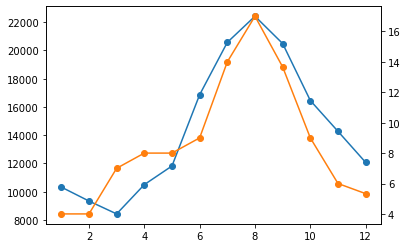

In [18]:
def rolling(x):
    roll = []
    for i in np.arange(1,13):
        if i==1:
            roll.append(np.mean([x[12],x[i],x[2]]))
        elif i==12:
            roll.append(np.mean([x[11],x[i],x[1]]))        
        else:
            roll.append(np.mean([x[i-1],x[i],x[i+1]]))                
    return roll

plt.plot(np.arange(1,13),rolling(temp[["month","wg10"]].query("wg10>15").month.value_counts().sort_index()),color="tab:blue",marker="o")

ax2=plt.gca().twinx()
melb_scw["month"] = pd.to_datetime(melb_scw.dt_utc).dt.month
plt.plot(np.arange(1,13),rolling(melb_scw.query("cluster==0").month.value_counts().sort_index()),color="tab:orange",marker="o")
